# Turn-over examples

In this notebook we will show how to perform turn-over fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.
See https://arxiv.org/pdf/2302.07484.pdf.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.arange(0., 0.12, 0.002)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk_interpolator = cosmo.get_fourier().pk_interpolator(of='delta_cb')
#from cosmoprimo import PowerSpectrumBAOFilter
#filter = PowerSpectrumBAOFilter(pk_interpolator, engine='peakaverage', cosmo=cosmo, cosmo_fid=cosmo)
#pk_interpolator = filter.smooth_pk_interpolator()
pk = pk_interpolator(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

## Turnover likelihood

In [2]:
from desilike.theories.galaxy_clustering import TurnOverPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = TurnOverPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = KaiserTracerPowerSpectrumMultipoles(template=template)
theory.init.params['sn0'].update(fixed=True)  # let's fix sn0
# transform='cubic' to gaussianize the likelihood, eq. 16 of https://arxiv.org/pdf/2302.07484.pdf
observable = TracerPowerSpectrumMultipolesObservable(data=mocks, covariance=mocks,  # fit mean of mocks
                                                     klim={0: [0.002, 0.09, 0.002]}, # fit monopole, between 0.001 and 0.1 h/Mpc 
                                                     theory=theory,
                                                     transform='cubic')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

[000000.51] [0/1] 08-04 21:15  ObservablesGaussianLikelihood INFO     Covariance matrix with 44 points built from 1000 observations.
[000000.52] [0/1] 08-04 21:15  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9550.


-5899.510476121485

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=2)

print(profiles.to_stats(tablefmt='pretty'))

[000002.80] [0/1] 08-04 21:15  MinuitProfiler            INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
+-------------------------------------+--------+---------+-------+
| chi2 / (44 - 4) = 47.86 / 40 = 1.20 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|                  m                  |  True  |  1.52   | 0.73  |
|                  n                  |  True  |  0.641  | 0.017 |
|                 qto                 |  True  |  0.674  | 0.068 |
|                 b1                  |  True  |  2.017  | 0.051 |
+-------------------------------------+--------+---------+-------+


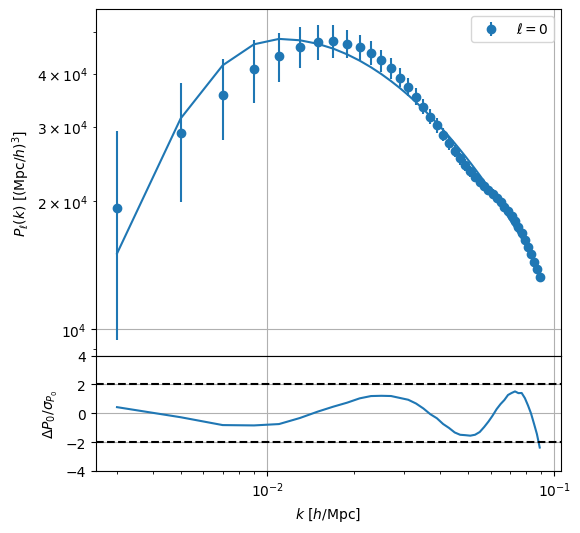

In [4]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot(scaling='loglog')
plt.show()

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [5]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.1})

[000012.38] [0/1] 08-04 21:15  EmceeSampler              INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
[000034.67] [0/1] 08-04 21:16  EmceeSampler              INFO     Diagnostics:
[000034.68] [0/1] 08-04 21:16  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 3.97; not < 0.1.
[000034.69] [0/1] 08-04 21:16  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.472.
[000034.98] [0/1] 08-04 21:16  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.806.
[000034.98] [0/1] 08-04 21:16  EmceeSampler              INFO     - max Geweke is 0.438.
[000034.99] [0/1] 08-04 21:16  EmceeSampler              INFO     - Geweke p-value is 0.233.
[000035.00] [0/1] 08-04 21:16  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 10.9.


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000055.31] [0/1] 08-04 21:16  EmceeSampler              INFO     Diagnostics:
[000055.32] [0/1] 08-04 21:16  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.331; not < 0.1.
[000055.33] [0/1] 08-04 21:16  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0346.
[000055.86] [0/1] 08-04 21:16  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.267.
[000055.87] [0/1] 08-04 21:16  EmceeSampler              INFO     - max Geweke is 0.297.
[000055.87] [0/1] 08-04 21:16  EmceeSampler              INFO     - Geweke p-value is 0.207.
[000055.89] [0/1] 08-04 21:16  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 12.3.
[000055.89] [0/1] 08-04 21:16  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.494.
[000076.00] [0/1] 08-04 21:17  EmceeSampler              INFO     Diagnostics:
[000076.01] [0/1] 08-04 21:17  EmceeSampler              INFO     

[000233.83] [0/1] 08-04 21:19  EmceeSampler              INFO     - Geweke p-value is 0.51.
[000233.85] [0/1] 08-04 21:19  EmceeSampler              INFO     - (1650 iterations / integrated autocorrelation time) is 29.9.
[000233.85] [0/1] 08-04 21:19  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.098.
[000254.10] [0/1] 08-04 21:19  EmceeSampler              INFO     Diagnostics:
[000254.12] [0/1] 08-04 21:19  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.361; not < 0.1.
[000254.13] [0/1] 08-04 21:19  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0332.
[000254.19] [0/1] 08-04 21:19  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.1.
[000254.20] [0/1] 08-04 21:19  EmceeSampler              INFO     - max Geweke is 0.649.
[000254.21] [0/1] 08-04 21:19  EmceeSampler              INFO     - Geweke p-value is 0.195.
[000254.23] [0/1] 08-04 21:19  EmceeSampler           

In [6]:
chain = chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+-----+--------+-------+--------+-------+-----------------+-----------------+
|     | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+-----+--------+-------+--------+-------+-----------------+-----------------+
|  m  |  1.45  | 1.81  |  1.68  | 0.85  |   -0.80/+0.79   |   -0.97/+0.54   |
|  n  | 0.642  | 0.638 | 0.638  | 0.017 |  -0.017/+0.017  |  -0.020/+0.013  |
| qto | 0.673  | 0.658 | 0.658  | 0.066 |  -0.069/+0.067  |  -0.064/+0.070  |
| b1  | 2.021  | 2.032 | 2.028  | 0.052 |  -0.052/+0.052  |  -0.054/+0.049  |
+-----+--------+-------+--------+-------+-----------------+-----------------+


Removed no burn in


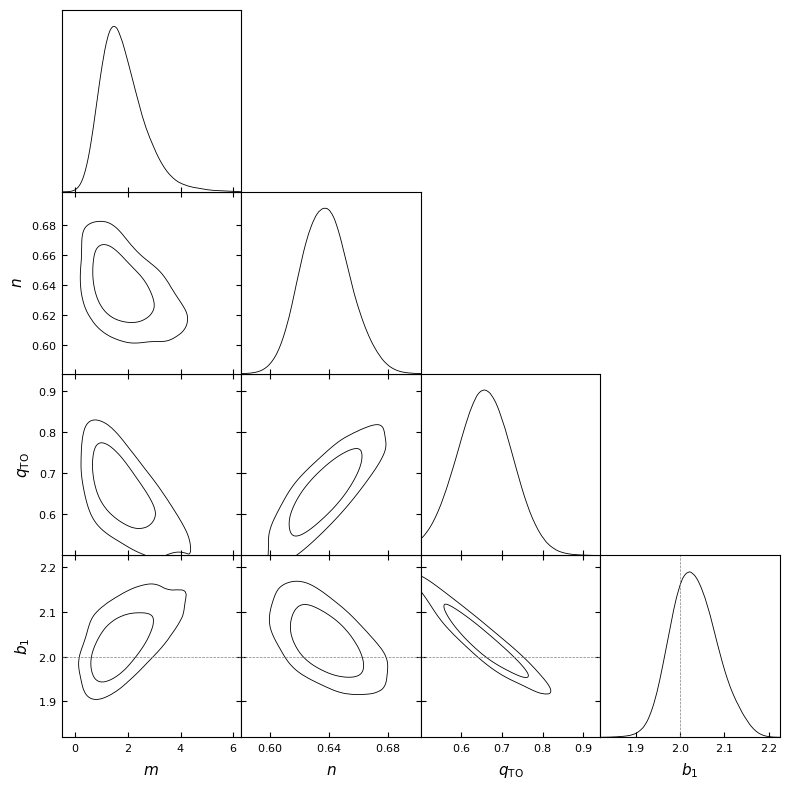

In [7]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qto': 1., 'b1': b})

$q_{\mathrm{TO}} = k_{\mathrm{TO}}^{\mathrm{obs}} / k_{\mathrm{TO}}^{\mathrm{fid}}$ is biased low, as noticed in fig. 1 of https://arxiv.org/pdf/2302.07484.pdf, and the $\chi^{2}$ is high.

## Deprojection of BAO wiggles
We follow section 2.2 of https://arxiv.org/pdf/2302.07484.pdf. Let's generate a model with BAO wiggles, fitting the data.

In [14]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate

template_bao = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
theory_bao = KaiserTracerPowerSpectrumMultipoles(template=template_bao)
observable_bao = observable.deepcopy()
observable_bao.init.update(theory=theory_bao, transform=None)
likelihood_bao = ObservablesGaussianLikelihood(observables=[observable_bao])

In [15]:
profiler = MinuitProfiler(likelihood_bao, seed=42)
profiles = profiler.maximize(niterations=1)
print(profiles.to_stats(tablefmt='pretty'))

[000533.37] [0/1] 08-04 21:24  ObservablesGaussianLikelihood INFO     Covariance matrix with 44 points built from 1000 observations.
[000533.37] [0/1] 08-04 21:24  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9550.
[000534.05] [0/1] 08-04 21:24  MinuitProfiler            INFO     Varied parameters: ['b1', 'sn0'].
+------------------------------------+--------+---------+-------+
| chi2 / (44 - 2) = 0.04 / 42 = 0.00 | varied | bestfit | error |
+------------------------------------+--------+---------+-------+
|                 b1                 |  True  |  2.001  | 0.021 |
|                sn0                 |  True  | -0.001  | 0.033 |
+------------------------------------+--------+---------+-------+


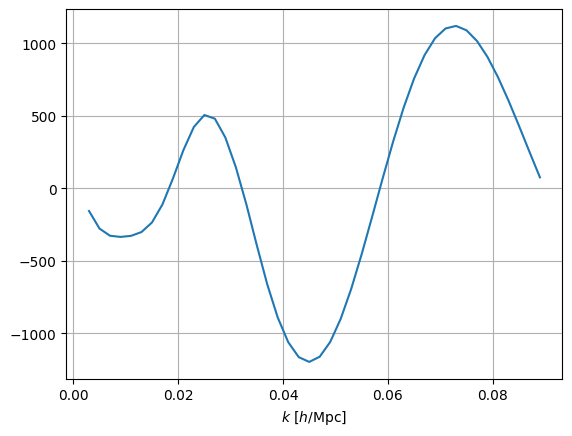

In [16]:
observable_bao(**profiles.bestfit.choice(input=True))
precision, theory_bao = likelihood_bao.precision, observable_bao.wmatrix.flatpower
template_bao.init.update(only_now=True)   # that removes BAO wiggles
observable_bao(**profiles.bestfit.choice(input=True))
theory_nobao = observable_bao.wmatrix.flatpower

# These are the BAO wiggles
diff = np.array(theory_bao - theory_nobao)
ax = plt.gca()
ax.plot(observable_bao.k[0], diff)
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.show()

In [17]:
def deprojection(precision, template):
    # template has shape (number of parameters, flatdata size)
    template = np.atleast_2d(template).T
    inv = np.linalg.inv(template.T.dot(precision).dot(template))
    return precision - precision.dot(template).dot(inv).dot(template.T).dot(precision)

# Let's deproject BAO, eq. 8 of https://arxiv.org/pdf/2302.07484.pdf
precision_deproj = deprojection(precision, diff)

In [18]:
# Let's use the new precision matrix
likelihood.init.update(precision=precision_deproj)

profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize(niterations=2)

print(profiles.to_stats(tablefmt='pretty'))

[000535.87] [0/1] 08-04 21:24  ObservablesGaussianLikelihood INFO     Covariance matrix with 44 points built from 1000 observations.
[000535.87] [0/1] 08-04 21:24  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9550.
[000535.87] [0/1] 08-04 21:24  MinuitProfiler            INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
+------------------------------------+--------+---------+-------+
| chi2 / (44 - 4) = 3.99 / 40 = 0.10 | varied | bestfit | error |
+------------------------------------+--------+---------+-------+
|                 m                  |  True  |  1.24   | 0.57  |
|                 n                  |  True  |  0.713  | 0.022 |
|                qto                 |  True  |  0.745  | 0.066 |
|                 b1                 |  True  |  2.030  | 0.048 |
+------------------------------------+--------+---------+-------+


In [19]:
sampler = EmceeSampler(likelihood, seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.1})

[000540.45] [0/1] 08-04 21:24  EmceeSampler              INFO     Varied parameters: ['m', 'n', 'qto', 'b1'].
[000560.76] [0/1] 08-04 21:25  EmceeSampler              INFO     Diagnostics:
[000560.77] [0/1] 08-04 21:25  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 11.2; not < 0.1.
[000560.79] [0/1] 08-04 21:25  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 3.58.
[000561.16] [0/1] 08-04 21:25  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 4.6.
[000561.17] [0/1] 08-04 21:25  EmceeSampler              INFO     - max Geweke is 1.39.
[000561.17] [0/1] 08-04 21:25  EmceeSampler              INFO     - Geweke p-value is 0.0533.
[000561.18] [0/1] 08-04 21:25  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 7.7.


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000582.80] [0/1] 08-04 21:25  EmceeSampler              INFO     Diagnostics:
[000582.81] [0/1] 08-04 21:25  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.571; not < 0.1.
[000582.82] [0/1] 08-04 21:25  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0952.
[000583.45] [0/1] 08-04 21:25  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.289.
[000583.45] [0/1] 08-04 21:25  EmceeSampler              INFO     - max Geweke is 0.474.
[000583.45] [0/1] 08-04 21:25  EmceeSampler              INFO     - Geweke p-value is 0.0446.
[000583.47] [0/1] 08-04 21:25  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 13.1.
[000583.47] [0/1] 08-04 21:25  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.3.
[000605.94] [0/1] 08-04 21:25  EmceeSampler              INFO     Diagnostics:
[000605.95] [0/1] 08-04 21:25  EmceeSampler              INFO     -

Removed no burn in
Removed no burn in


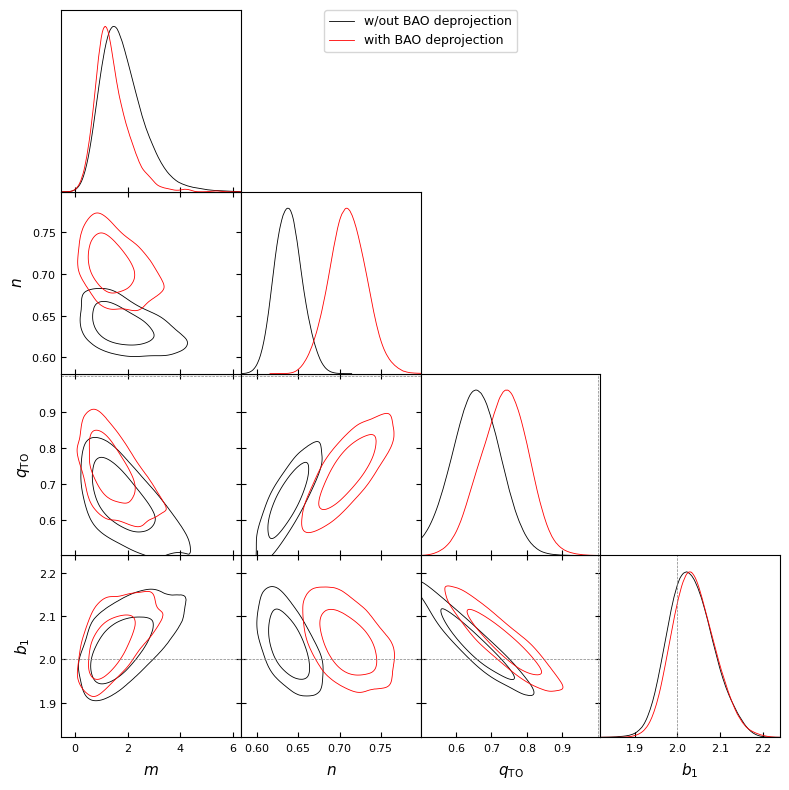

In [20]:
chain_deproj = chains[0].remove_burnin(0.5)[::10]
# A bit better, but... not too much. My feeling is the initial template is overconstrained (for this k fitting range)
from desilike.samples import plotting
plotting.plot_triangle([chain, chain_deproj], markers={'qto': 1., 'b1': b}, labels=['w/out BAO deprojection', 'with BAO deprojection'])